# part 1: 


In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

/home/xzhang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.3.0
Numpy version: 1.23.4
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/envs/swincell/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.19.3
scipy version: 1.9.3
Pillow version: 9.3.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.1
psutil version: 5.9.8
pandas version: 1.3.4
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.1
pynrrd version: 1.0.0
clearml version: 1.14.5rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# test loading nanolive images 

In [29]:
from monai.transforms import  Transform, MapTransform
import torch
import numpy as np
# from monai.utils.enums import TransformBackends
# class Cellpose_reshape(Transform):
#     """
#     """

#     # backend = [TransformBackends.TORCH, TransformBackends.NUMPY]

#     def __call__(self, img):
#         # if img has channel dim, squeeze it
#         if img.ndim == 4 and img.shape[0] == 1:
#             img = img.squeeze(0)
#         print('input shape',img.shape)
#         # print('image shape',img.shape,'img dtype',img.dtype)
#         # result = torch.reshape(img, (4, 512,512,96))
#         result = np.reshape(img, (4, 512,512,96),order='C')  #"C/A/F"
#         # result =np.array(np.split(img,4,axis=2))
#         # result = np.uint8(result)
#         result[0] = np.uint8(result[0]>0)
#         result[1:] = (result[1:] - 127)/127
#         # print('result shape',result.shape,result.dtype) #(4, 96, 512, 512)
        
        
#         # result =np.zeros((4, 512,512,96),dtype=np.uint8)
#         return result

class Cellpose_reshape(Transform):
    #split 4 channels

    # backend = [TransformBackends.TORCH, TransformBackends.NUMPY]
    def __call__(self, img):
        # if img has channel dim, squeeze it
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)
        # print('input shape',img.shape)
        # print('image shape',img.shape,'img dtype',img.dtype)
        # result = torch.reshape(img, (4, 512,512,96))
        # result = np.reshape(img, (4, 512,512,96),order='C')  #"C/A/F"
        result =np.array(np.split(img,4,axis=2))
        # result = np.uint8(result)
        result[0] = np.uint8(result[0]>0)
        result[1:] = (result[1:] - 127)/127
        # print('result shape',result.shape,result.dtype) #(4, 96, 512, 512)
        
        
        # result =np.zeros((4, 512,512,96),dtype=np.uint8)
        return result
class Cellpose_reshaped(MapTransform):


    # backend = Cellpose_reshape.backend

    def __init__(self, keys, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.converter = Cellpose_reshape()

    def __call__(self, data):
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.converter(d[key])
        return d

In [24]:
a =np.zeros((512, 512, 384),dtype=np.uint8)
# b = np.array(np.split(a,4,axis=2)) #(4, 512, 512, 96)
b = np.array(np.split(a,4,axis=2)) #(4, 512, 512, 96)
print(b.shape)

(4, 512, 512, 96)


In [30]:

import glob
from monai import data, transforms
import matplotlib.pyplot as plt
import torch
data_dir = '/data/download_data/Nanolive_mem_cellpose_data_v5_nor_1_99/'
# data_dir="/data/download_data/quilt-data-access-tutorials-main/all_fov/allen10"
# data_dir="/data/download_data/colon_dataset/colon_30_hdf/"
# data_dir="/data/download_data/colon_dataset/colon_5/"
N = len(os.listdir(os.path.join(data_dir,'images')))


img_full_paths = sorted(glob.glob(os.path.join(data_dir,'images/*')))

label_full_paths = sorted(glob.glob(os.path.join(data_dir,'masks_with_flows/*.tiff')))
# label_full_paths = sorted(glob.glob(os.path.join(data_dir,'labels/*')))
print(len(img_full_paths))

if len(img_full_paths)<5:
    img_full_paths = img_full_paths * 10
    label_full_paths = label_full_paths * 10
valid_img_full_paths = img_full_paths[::5]
valid_label_full_paths = label_full_paths[::5]

train_img_full_paths = [f for i,f in enumerate(img_full_paths) if i%5 != 0]
train_label_full_paths = [f for i,f in enumerate(label_full_paths) if i%5 != 0]


train_datalist = [{'image':image,'label':label} for image,label in zip(train_img_full_paths,train_label_full_paths)]    
val_datalist = [{'image':image,'label':label} for image,label in zip(valid_img_full_paths,valid_label_full_paths)]  
# [{'image':i} for i in valid_img_full_paths] +[{'label':i} for i in valid_label_full_paths]
# with open("sample.json", "w") as outfile:
#     json.dump(train_datalist, outfile)
print(len(train_datalist),len(val_datalist))

downsample_factor = 1
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        Cellpose_reshaped(keys=["label"]),
        # transforms.SplitChannelD(keys=["label"],),
        # transforms.AsDiscreted(keys=["label"],threshold=1),
        # transforms.AddChanneld(keys=["image", "label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=(512//downsample_factor,512//downsample_factor,96//downsample_factor)),
        # transforms.Resized(keys=["image", "label"],spatial_size=(512,512,96)),
        # transforms.RandZoomd(keys=["image", "label"],prob=1,min_zoom=0.2,max_zoom=5),
        # transforms.Spacingd(
        #     keys=["image", "label"], pixdim=(args.space_x, args.space_y, args.space_z), mode=("bilinear", "nearest")
        # ),
        transforms.ScaleIntensityRanged(
            keys=["image"], a_min=19000, a_max=31000, b_min=0, b_max=1, clip=True
        ),
        transforms.RandSpatialCropSamplesd(
            keys=["image","label"],
            roi_size=[96,96,32],
            # roi_size=[128,128,32],
            num_samples=2,
            random_center=True,
            random_size=False,
        ),

        # transforms.RandSpatialCropd(
        #     keys=["image","label"],
        #     roi_size=[96,96,96],
        #     # num_samples=2,
        #     # random_center=True,
        #     random_size=False,
        # ),
        # transforms.RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=0),
        # transforms.RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=1),
        # transforms.RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=2),
        # transforms.RandRotate90d(keys=["image", "label"], prob=0.1, max_k=3),
        # transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=0.1),
        # transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=0.1),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)
valid_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # transforms.AsDiscreted(keys=["label"],threshold=1),
        # transforms.AddChanneld(keys=["image", "label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=(512,512,96)),
        transforms.ScaleIntensityRanged(
            keys=["image"], a_min=21000, a_max=31000, b_min=0, b_max=1, clip=True
            # keys=["image"], a_min=300, a_max=400, b_min=0, b_max=1, clip=True
        ),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)

train_ds = data.Dataset(data=train_datalist, transform=train_transform)
train_loader = data.DataLoader(
        train_ds, batch_size=1, num_workers=8, sampler=None, drop_last=True
    )
valid_ds = data.Dataset(data=val_datalist, transform=valid_transform)
valid_loader = data.DataLoader(
        valid_ds, batch_size=1, num_workers=8, sampler=None, drop_last=True
    )
n_row = 1


10
8 2


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3dd4f4e50>
Traceback (most recent call last):
  File "/home/xzhang/anaconda3/envs/swincell/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/xzhang/anaconda3/envs/swincell/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/xzhang/anaconda3/envs/swincell/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc3dd4f4e50>
Traceback (most recent call last):
  File "/home/xzhang/anaconda3/envs/swincell/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__d

torch.Size([2, 1, 96, 96, 32]) torch.Size([2, 4, 96, 96, 32])
metatensor(0.) metatensor(0.)
mask2 metatensor(0.) metatensor(0.)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

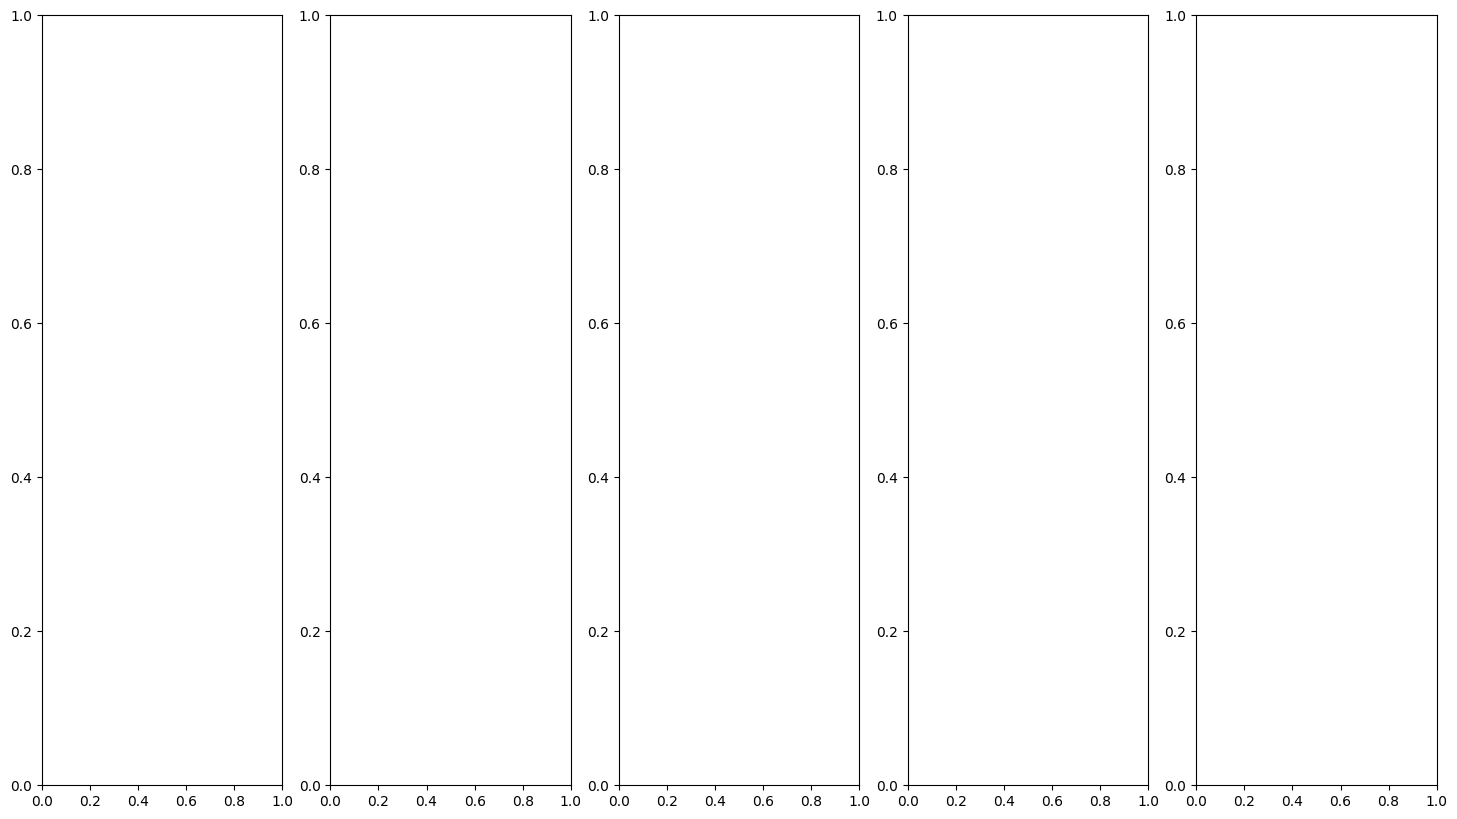

In [31]:
fig, axes = plt.subplots(n_row, 5,sharex=False, sharey=False, figsize=(18,10))
n=0
# for i in valid_loader:
# for i in train_loader:
for i in range(n_row):
    datai = next(iter(train_loader))
    img2plot=datai['image']
    label2plot=datai['label']
    # img2plot,label2plot = next(iter(train_loader))
    print(img2plot.shape, label2plot.shape)

    top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()

    # mask0= torch.max(label2plot[0,0,0,:,:,:],dim=-1)[0].detach().cpu()
    # mask1= torch.max(label2plot[0,0,1,:,:,:],dim=-1)[0].detach().cpu()
    # mask2= torch.max(label2plot[0,0,2,:,:,:],dim=-1)[0].detach().cpu()
    # mask3= torch.max(label2plot[0,0,2,:,:,:],dim=-1)[0].detach().cpu()
    zzz = 16
    # mask0= label2plot[0,0,0,:,:,zzz].detach().cpu()
    # mask1= label2plot[0,0,1,:,:,zzz].detach().cpu()
    # mask2= label2plot[0,0,2,:,:,zzz].detach().cpu()
    # mask3= label2plot[0,0,3,:,:,zzz].detach().cpu()
    # mask0= label2plot[0,0,:,:,zzz].detach().cpu()
    mask0= label2plot[0,0,:,:,zzz].detach().cpu()
    mask1= label2plot[0,1,:,:,zzz].detach().cpu()
    mask2= label2plot[0,2,:,:,zzz].detach().cpu()
    mask3= label2plot[0,3,:,:,zzz].detach().cpu()
    # mask1= label2plot[0,0,1,zzz,:,:].detach().cpu()
    # mask2= label2plot[0,0,2,:,zzz,:].detach().cpu()
    # mask3= label2plot[0,0,3,:,:,zzz].detach().cpu()
    # side_label= torch.max(label2plot[0,0,:,:,:],dim=-2)[0].detach().cpu()
    print(mask0.max(),mask0.min())
    print('mask2',mask2.max(),mask2.min())
    axes[n,0].imshow(img2plot[0,0,:,:,zzz])

    
    axes[n,1].imshow(mask0)
    axes[n,2].imshow(mask1)
    axes[n,3].imshow(mask2)
    axes[n,4].imshow(mask3)



In [4]:
args ={'checkpoint': None,
        'amp': False,
        'batch_size': 1,
        'cellpose': True,
        'max_epochs':5,
        'optim_lr': 0.001,
        'model': 'swin',
        'num_workers': 8,
        'optimizer': 'adam',
        'resume': None,
        'save_temp_img': False,
        'seed': 0,
        'test_mode': False,
        'threshold': 0.5,
        'weight_decay': 0.0001,
        'world_size': 1,
        'workers': 8}


In [5]:
from monai.networks.nets import SwinUNETR
from swincell.utils.utils import AverageMeter, distributed_all_gather
model = SwinUNETR(
            img_size=(32,32,32),
            in_channels=1,
            out_channels=4,
            feature_size=48,
            use_checkpoint=None,
        )

from torch.nn import MSELoss,BCEWithLogitsLoss
from monai.losses import DiceLoss
dice_loss1 = MSELoss(reduction='mean')
dice_loss2 = DiceLoss(to_onehot_y=False, sigmoid=True)
# dice_loss2 = BCEWithLogitsLoss(reduction='mean')
dice_loss = [dice_loss1,dice_loss2]

optimizer = torch.optim.SGD(
            model.parameters(), lr=0.001, momentum=0.99, nesterov=True, weight_decay=1e-5
        )

for epoch in range(10):
    model.train()
    run_loss = AverageMeter()
    for i, data in enumerate(train_loader):
        loss_func1 = dice_loss[0]
        loss_func2 = dice_loss[1]
        data, target = data['image'], data['label']
        logits = model(data)
        #  weight_factor*flow loss     +      cell probability loss
        loss = 5*loss_func1(logits[:,1:], target[:,1:]) + loss_func2(logits[:,0], target[:,0])
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=args.batch_size)

RuntimeError: DataLoader worker (pid(s) 36397) exited unexpectedly

torch.Size([512, 512, 384])
torch.Size([512, 512, 384])
(4, 512, 512, 96)
(4, 512, 512, 96)


IndexError: index 48 is out of bounds for dimension 4 with size 32

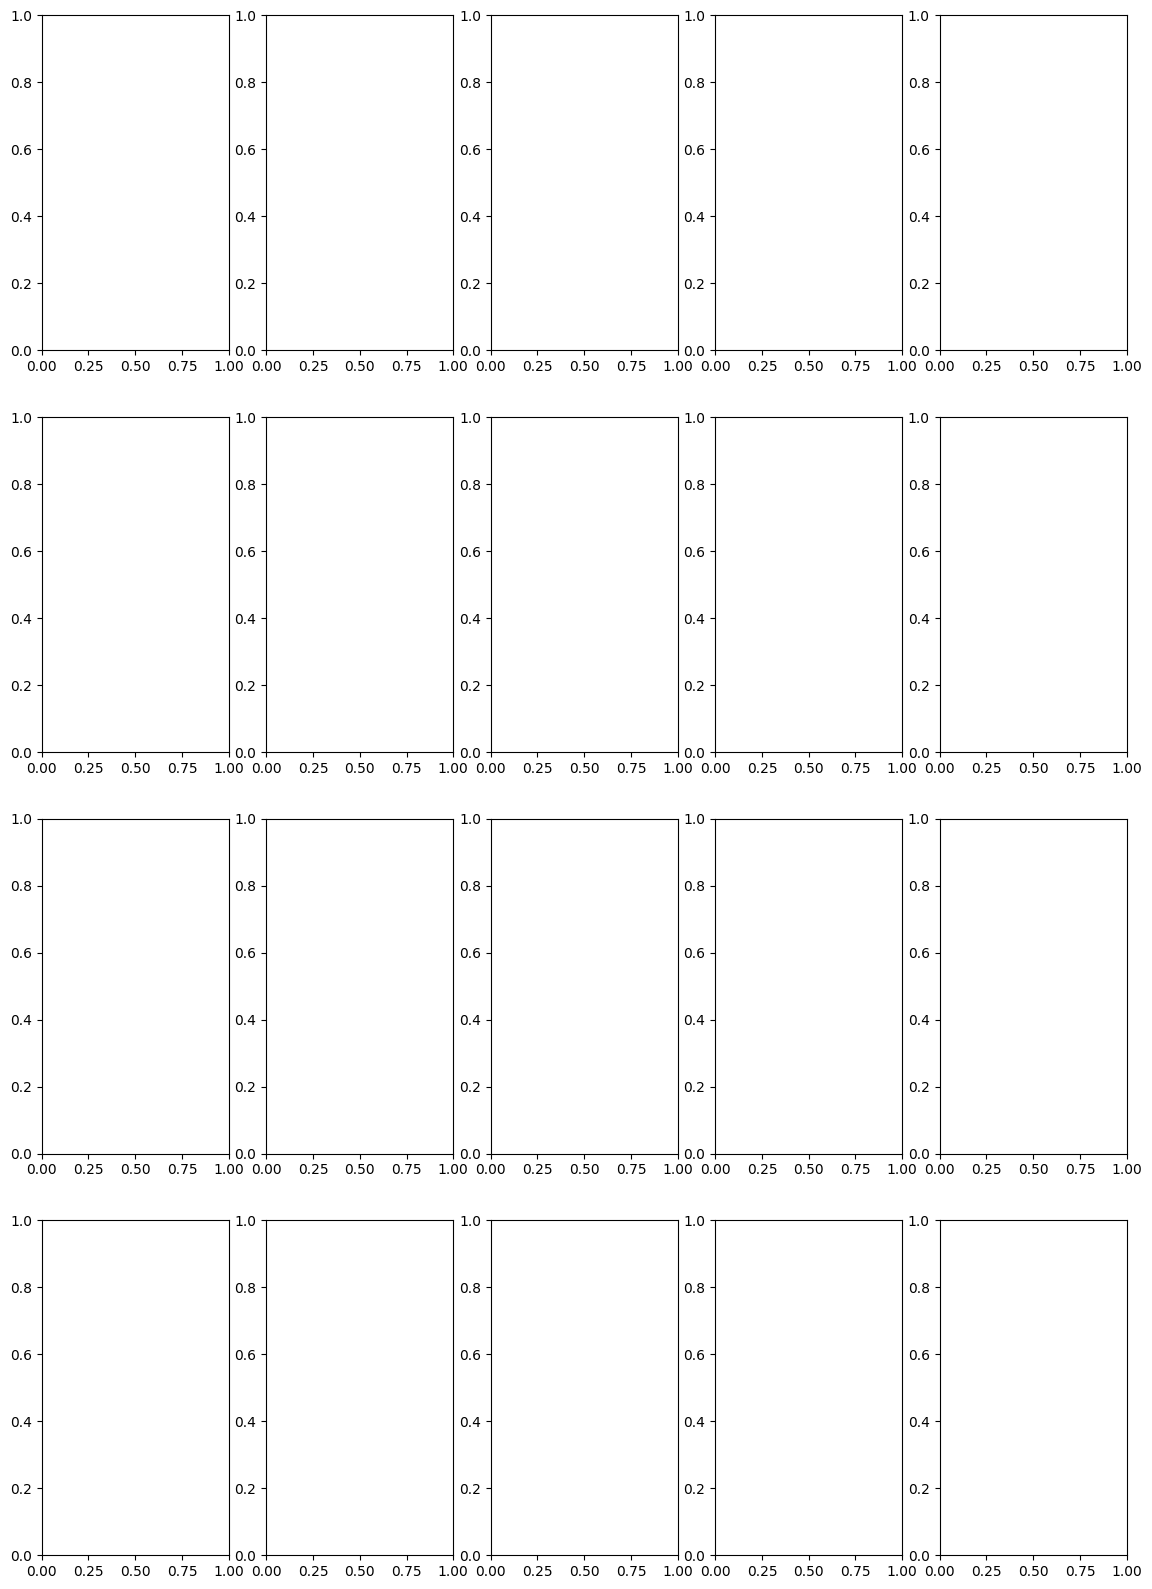

In [13]:
n_row = 4
fig, axes = plt.subplots(n_row, 5,sharex=False, sharey=False, figsize=(14,20))
n=0
for i in train_loader:

    img2plot=i['image']
    label2plot=i['label']
    # print(img2plot.shape)
    # fig,axes = plt.subplots(1,5)
    top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()
    top_label= torch.max(label2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()
    side= torch.max(img2plot[0,0,:,:,:],dim=-2)[0].detach().cpu()
    side_label= torch.max(label2plot[0,0,:,:,:],dim=-2)[0].detach().cpu()
    # print(test,test.shape)
    axes[n,0].imshow(img2plot[0,0,:,:,48])

    
    axes[n,1].imshow(top)
    axes[n,2].imshow(top_label)
    axes[n,3].imshow(side)
    axes[n,4].imshow(side_label)
    n +=1
    if n>=n_row:
        break

# test loading multiclass images

In [2]:
from monai.transforms import Transform,MapTransform
from monai.utils.enums import TransformBackends
from monai.config.type_definitions import NdarrayOrTensor
from monai.config import DtypeLike, KeysCollection
from typing import Any, Callable, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union, cast


# class ConvertToMultiChannelNanolive(Transform):
#     """
#     Convert labels to multi channels based on brats18 classes:
#     label 1 is the necrotic and non-enhancing tumor core
#     label 2 is the peritumoral edema
#     label 4 is the GD-enhancing tumor
#     The possible classes are TC (Tumor core), WT (Whole tumor)
#     and ET (Enhancing tumor).
#     """

#     backend = [TransformBackends.TORCH, TransformBackends.NUMPY]

#     def __call__(self, img: NdarrayOrTensor) -> NdarrayOrTensor:
#         # if img has channel dim, squeeze it
#         if img.ndim == 4 and img.shape[0] == 1:
#             img = img.squeeze(0)

#         result = [(img == 1) | (img == 4), (img == 1) | (img == 4) | (img == 2), img == 4]
#         # result = [(img == 1) , (img == 2)]
#         # merge labels 1 
#         return torch.stack(result, dim=0) if isinstance(img, torch.Tensor) else np.stack(result, axis=0)


# class ConvertToMultiChannelNanolived(MapTransform):

#     backend = ConvertToMultiChannelNanolive.backend

#     def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False):
#         super().__init__(keys, allow_missing_keys)
#         self.converter = ConvertToMultiChannelNanolive()

#     def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
#         d = dict(data)
#         for key in self.key_iterator(d):
#             d[key] = self.converter(d[key])
#         return d
# a = monai.transforms.ConvertToMultiChannelBasedOnBratsClassesd
# import monai.transforms.ConvertToMultiChannelBasedOnBratsClassesd
# print(monai.transforms.ConvertToMultiChannelBasedOnBratsClassesd.__file__)
import inspect
# inspect.getmodule(monai.transforms.ConvertToMultiChannelBasedOnBratsClassesd.__class__)

# import sys,os

# os.path.abspath(sys.modules[monai.transforms.ConvertToMultiChannelBasedOnBratsClassesd.__module__].__file__)

9 3
torch.Size([1, 1, 512, 512, 96]) torch.Size([1, 2, 512, 512, 96]) tensor(True) tensor(False)
torch.Size([1, 1, 512, 512, 96]) torch.Size([1, 2, 512, 512, 96]) tensor(True) tensor(False)


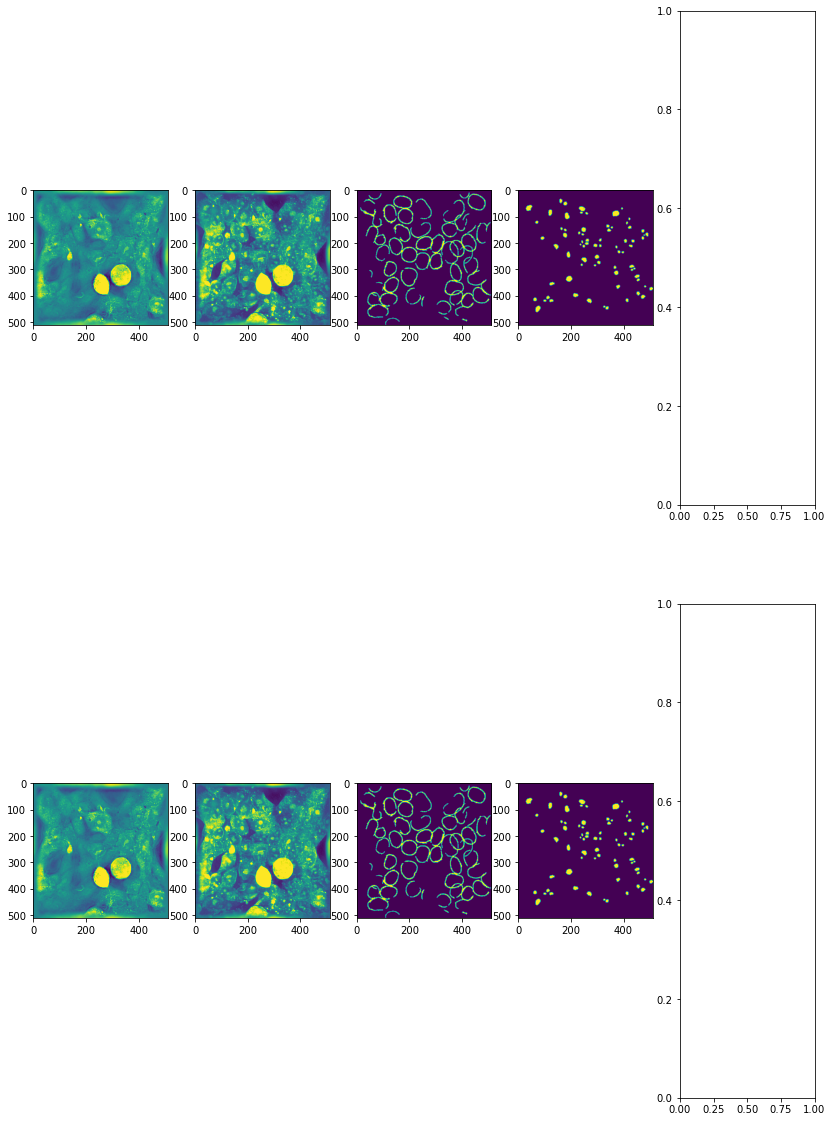

In [1]:

import glob
from monai import data, transforms
import matplotlib.pyplot as plt
import torch
from monai.transforms import MapTransform
import os
# converttomultichannel defined here:
# /home/xzhang/anaconda3/envs/monai/lib/python3.9/site-packages/monai/transforms

data_dir = '/data/programs/monai_research_contributions/SwinUNETR/Nanolive_dataset_mem_2c'

N = len(os.listdir(os.path.join(data_dir,'image')))
# print(N)
split = int(0.8*N) # default 80% for training 
img_full_paths = sorted(glob.glob(os.path.join(data_dir,'image/*')))
label_full_paths = sorted(glob.glob(os.path.join(data_dir,'label/*')))
valid_img_full_paths = img_full_paths[::5]
valid_label_full_paths = label_full_paths[::5]
train_img_full_paths = [f for f in img_full_paths if f not in valid_img_full_paths]
train_label_full_paths = [f for f in label_full_paths if f not in valid_label_full_paths]

train_datalist = [{'image':image,'label':label} for image,label in zip(train_img_full_paths,train_label_full_paths)]    
val_datalist = [{'image':image,'label':label} for image,label in zip(valid_img_full_paths,valid_label_full_paths)]  
# [{'image':i} for i in valid_img_full_paths] +[{'label':i} for i in valid_label_full_paths]
# with open("sample.json", "w") as outfile:
#     json.dump(train_datalist, outfile)
print(len(train_datalist),len(val_datalist))



train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # transforms.AsDiscreted(keys=["label"],threshold=1),
        transforms.AsDiscreted(keys=["label"],to_onehot=2),
        # transforms.AddChanneld(keys=["image", "label"]),
        transforms.AddChanneld(keys=["image"]),
        # transforms.Resized(keys=["image", "label"],spatial_size=(512,512,96)),
        transforms.RandZoomd(keys=["image", "label"],prob=0.5,min_zoom=0.85,max_zoom=1.15),
        # transforms.Spacingd(
        #     keys=["image", "label"], pixdim=(args.space_x, args.space_y, args.space_z), mode=("bilinear", "nearest")
        # ),
        transforms.ScaleIntensityRanged(
            keys=["image"], a_min=21000, a_max=31000, b_min=0, b_max=1, clip=True
        ),
        transforms.RandSpatialCropSamplesd(
            keys=["image","label"],
            roi_size=[96,96,96],
            num_samples=2,
            random_center=True,
            random_size=False,
        ),
        transforms.RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=0),
        transforms.RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=1),
        transforms.RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=2),
        transforms.RandRotate90d(keys=["image", "label"], prob=0.1, max_k=3),
        transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=0.1),
        transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=0.1),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)
valid_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # transforms.EnsureChannelFirstd(keys=["image","label"]),
        # transforms.AsDiscreted(keys=["label"],threshold=2),
        # ConvertToMultiChannel(keys="label"),
        transforms.AddChanneld(keys=["image"]),
        transforms.ConvertToMultiChannelNanolived(keys="label"),
        # transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        # ConvertToMultiChannelNanolived(keys="label"),
        # transforms.AsDiscreted(keys=["label"],to_onehot=1),
        # transforms.AddChanneld(keys=["image", "label"]),
        # transforms.Resized(keys=["image", "label"],spatial_size=(512,512,96)),
        transforms.ScaleIntensityRanged(
            # keys=["image"], a_min=18000, a_max=26000, b_min=0, b_max=1, clip=True
            keys=["image"], a_min=21000, a_max=31000, b_min=0, b_max=1, clip=True
        ),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)


# train_ds = data.Dataset(data=train_datalist, transform=train_transform)
# train_loader = data.DataLoader(
#         train_ds, batch_size=1, num_workers=24, sampler=None, drop_last=True
#     )
valid_ds = data.Dataset(data=val_datalist, transform=valid_transform)
valid_loader = data.DataLoader(
        valid_ds, batch_size=1, num_workers=24, sampler=None, drop_last=True
    )
n_row = 2
fig, axes = plt.subplots(n_row, 5,sharex=False, sharey=False, figsize=(14,20))
n=0
for i in valid_loader:

    img2plot=i['image']
    label2plot=i['label']
    print(img2plot.shape, label2plot.shape,label2plot.max(),label2plot.min())
    # print(img2plot.shape)
    # fig,axes = plt.subplots(1,5)
    top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()
    top_label= torch.max(label2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()
    side= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()
    label1= torch.max(label2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()
    label2= torch.max(label2plot[0,1,:,:,:],dim=-1)[0].detach().cpu()
    # label3= torch.max(label2plot[0,2,:,:,:],dim=-1)[0].detach().cpu()
    # print(test,test.shape)
    axes[n,0].imshow(img2plot[0,0,:,:,48])

    
    axes[n,1].imshow(top)
    axes[n,2].imshow(label1)
    axes[n,3].imshow(label2)
    # axes[n,4].imshow(label3)
    n +=1
    if n>=n_row:
        break

In [2]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from functools import partial
# from monai.transforms import RemoveSmallObjects,FillHoles
# from monai.transforms import FillHoles
from monai.transforms import Activations, AsDiscrete, Compose,FillHoles
model_path = '/data/programs/monai_research_contributions/SwinUNETR/allen/runs/Nanolive_finetune3/foldNone/model_final.pt'
model = SwinUNETR(
    img_size=(96,96,96),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=False,
).cuda(0)
model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    roi_size=(96,96,96),
    # roi_size=(128,128,96),

    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
)
post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=False, logit_thresh=1.01)
post_pred = AsDiscrete(argmax=False, threshold=0.6)



# print(val_output_convert.shape)


In [3]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=0.5),
    # RemoveSmallObjects(min_size = 100),
    FillHoles(applied_labels=None, connectivity=2)

])

with torch.no_grad():
        for idx, batch_data in enumerate(valid_loader):
            data_raw, target = batch_data["image"], batch_data["label"]
            data_raw, target = data_raw.cuda(0), target.cuda(0)
            # with autocast(enabled=True):
            logits = model_inferer(data_raw)
            # val_labels_list = decollate_batch(target)
            # val_outputs_list = decollate_batch(logits)
            print(logits.max(),logits.min())
            val_labels_list = target
            val_outputs_list = logits
            # val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            a = post_sigmoid(val_outputs_list)
            print('after sigmoid',a.max(),a.min(),a.median())
            val_output_convert1 = post_pred(post_sigmoid(val_outputs_list))
            val_output_convert2 = post_trans(logits)
            print(val_output_convert1.max(),val_output_convert1.min(),val_output_convert1.median())

tensor(268.0057, device='cuda:0') tensor(-16.6058, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.1402e-08, device='cuda:0') tensor(0.0005, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(268.0057, device='cuda:0') tensor(-16.6058, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.1402e-08, device='cuda:0') tensor(0.0005, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(232.3488, device='cuda:0') tensor(-15.7250, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(1.4816e-07, device='cuda:0') tensor(0.0005, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')


torch.Size([1, 1, 512, 512, 96])
(512, 512, 30) (512, 512)


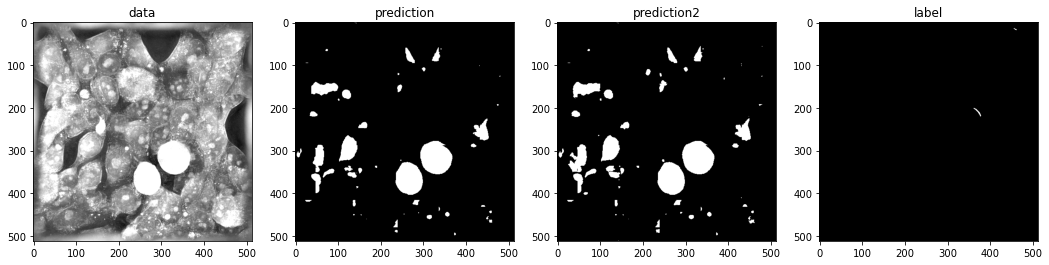

In [4]:
print(val_output_convert1.shape)
import numpy as np
plt.figure("image", (18, 6))
plt.subplot(1, 4, 1)
plt.title("data")
# image1 = np.max(data[0].detach().cpu()[0,:, :, 30:60],axis = -1)
image0 = data_raw[0].detach().cpu().numpy()[0,:, :, 30:60]
image1 = np.max(image0, axis=-1)

print(image0.shape, image1.shape)
plt.imshow(image1, cmap="gray")
plt.subplot(1, 4, 2)
plt.title("prediction")
pred = val_output_convert1.detach().cpu().numpy()[0,0,:, :, 35:55]
pred = np.max(pred, axis=-1)
plt.imshow(pred, cmap="gray")

plt.subplot(1, 4, 3)
plt.title("prediction2")
pred2 = val_output_convert2.detach().cpu().numpy()[0,0,:, :, 30:60]
pred2 = np.max(pred2, axis=-1)
plt.imshow(pred2, cmap="gray")

plt.subplot(1, 4, 4)
plt.title("label")
plt.imshow(target[0].detach().cpu()[0,:, :, 48], cmap="gray")

plt.show()



# test inference

In [27]:
root_dir = '/data/download_data/quilt-data-access-tutorials-main/all_fov/'
df = pd.read_csv(root_dir+'meta_info.csv')

# input_dir=df['fov_path'].unique()[100:220].tolist()
# target_dir=df['fov_seg_path'].unique()[100:220].tolist()
# train_img_paths =input_dir[:100]
# train_label_paths = target_dir[:100]
# valid_img_paths =input_dir[100:]
# valid_label_paths = target_dir[100:]

input_dir=df['fov_path'].unique()[300:320].tolist()
# target_dir=df['fov_seg_path'].unique()[:20].tolist()
train_img_paths =input_dir[:20]



train_img_full_paths =[os.path.join(root_dir,'fov_path_channel/'+file.split('/')[-1]) for file in train_img_paths]





test_datalist = [{'image':a} for a in train_img_full_paths] 
test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.AddChanneld(keys=["image"]),
        transforms.Resized(keys=["image"],spatial_size=(512,512,96)),
        # transforms.ScaleIntensityRanged(
        #     keys=["image"], a_min=18000, a_max=26000, b_min=0, b_max=1, clip=True
        # ),
        transforms.ToTensord(keys=["image"]),
    ]
)

test_ds = data.Dataset(data=test_datalist, transform=test_transform)
test_loader = data.DataLoader(
        test_ds, batch_size=1, num_workers=24, sampler=None, drop_last=True
    )

Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.


In [28]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from functools import partial
# from monai.transforms import RemoveSmallObjects,FillHoles
# from monai.transforms import FillHoles
from monai.transforms import Activations, AsDiscrete, Compose,FillHoles
model_path = '/data/programs/monai_research_contributions/SwinUNETR/allen/runs/Nanolive_finetune3/foldNone/model_final.pt'
model = SwinUNETR(
    img_size=(96,96,96),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=False,
).cuda(0)
model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    roi_size=(96,96,96),
    # roi_size=(128,128,96),

    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
)
post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=False, logit_thresh=1.01)
post_pred = AsDiscrete(argmax=False, threshold=0.6)

In [31]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=0.5),
    # RemoveSmallObjects(min_size = 100),
    FillHoles(applied_labels=None, connectivity=2)

])

with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
            data_test = batch_data["image"]
            data_test = data_test.cuda(0)
            # with autocast(enabled=True):
            logits = model_inferer(data_test)
            # val_labels_list = decollate_batch(target)
            # val_outputs_list = decollate_batch(logits)
            print(logits.max(),logits.min())

            test_outputs_list = logits
            # val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            a = post_sigmoid(test_outputs_list)
            print('after sigmoid',a.max(),a.min(),a.median())
            test_output_convert1 = post_pred(post_sigmoid(test_outputs_list))
            test_output_convert2 = post_trans(logits)
            # print(val_output_convert1.max(),val_output_convert1.min(),val_output_convert1.median())

tensor(107.0293, device='cuda:0') tensor(-12.1564, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(5.2544e-06, device='cuda:0') tensor(0.0052, device='cuda:0')
tensor(85.8323, device='cuda:0') tensor(-15.6975, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(1.5228e-07, device='cuda:0') tensor(0.0061, device='cuda:0')
tensor(49.4350, device='cuda:0') tensor(-14.2095, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.7435e-07, device='cuda:0') tensor(0.0054, device='cuda:0')
tensor(71.0185, device='cuda:0') tensor(-12.2007, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(5.0267e-06, device='cuda:0') tensor(0.0056, device='cuda:0')
tensor(49.4618, device='cuda:0') tensor(-12.0011, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.1371e-06, device='cuda:0') tensor(0.0057, device='cuda:0')
tensor(43.2879, device='cuda:0') tensor(-11.9350, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tenso

(512, 512, 30) (512, 512)


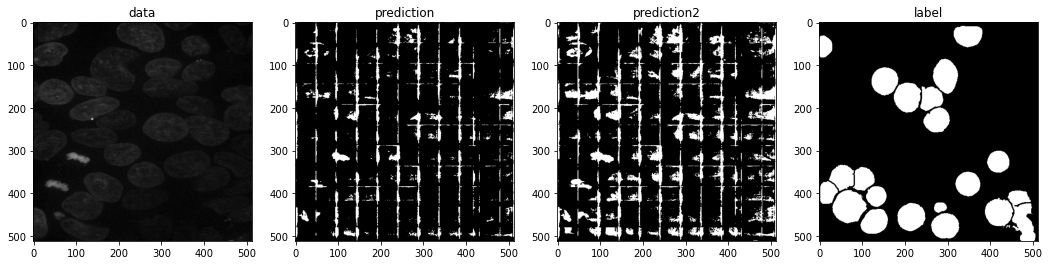

In [32]:
import numpy as np
plt.figure("image", (18, 6))
plt.subplot(1, 4, 1)
plt.title("data")
# image1 = np.max(data[0].detach().cpu()[0,:, :, 30:60],axis = -1)
image0 = data_test[0].detach().cpu().numpy()[0,:, :, 30:60]
image1 = np.max(image0, axis=-1)

print(image0.shape, image1.shape)
plt.imshow(image1, cmap="gray")
plt.subplot(1, 4, 2)
plt.title("prediction")
pred = test_output_convert1.detach().cpu().numpy()[0,0,:, :, 30:65]
pred = np.max(pred, axis=-1)
plt.imshow(pred, cmap="gray")

plt.subplot(1, 4, 3)
plt.title("prediction2")
pred2 = test_output_convert2.detach().cpu().numpy()[0,0,:, :, 30:65]
pred2 = np.max(pred2, axis=-1)
plt.imshow(pred2, cmap="gray")

plt.subplot(1, 4, 4)
plt.title("label")
# plt.imshow(target[0].detach().cpu()[0,:, :, 48], cmap="gray")

plt.show()

In [163]:
label = '/data/download_data/colon_dataset/colon_30_hdf/labels/*.h5'
label_files = natsorted(glob.glob(label))
print(label_files[0]) 
with h5py.File(label_files[0], 'r') as file:

    image = np.array(file['Image']) 
    print(image.shape)
    # print(np.unique(image))

/data/download_data/colon_dataset/colon_30_hdf/labels/image-labels_0000.h5
(129, 1030, 1300)


In [164]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [165]:
import matplotlib.pyplot as plt
import numpy as np

(4, 129, 1030, 1300)


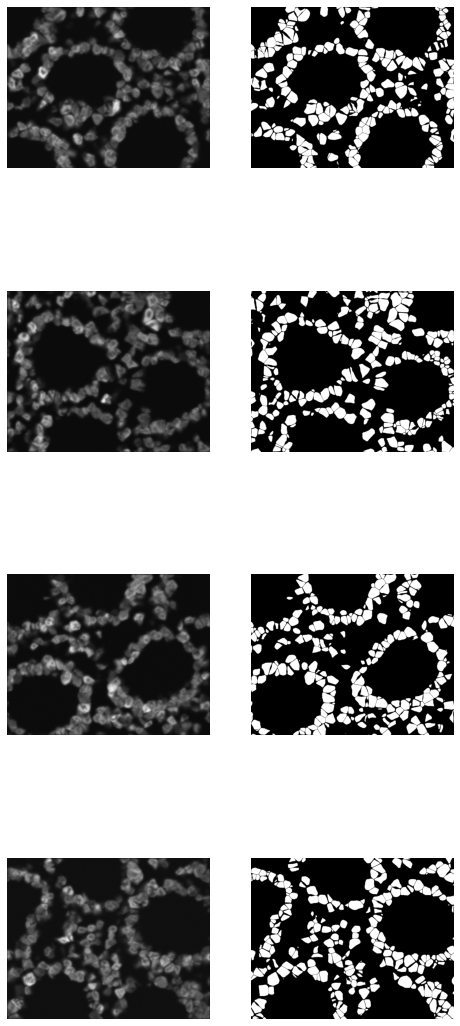

peak memory: 30270.88 MiB, increment: 10386.96 MiB


In [166]:
%%memit 

images,label = next(iter(data_loader))

# Convert the tensor to numpy for visualization
# Adjust this step if your data needs special handling or normalization
images = images.numpy()
print(images.shape)
# Plot the first few images in the batch
fig, ax = plt.subplots(4, 2, figsize=(8, 20))  # Adjust the number of images you want to display
for i in range(4):
    ax[i][0].imshow(images[i][60].squeeze(), cmap='gray')
    ax[i][1].imshow(label[i][60].squeeze(), cmap='gray')
    ax[i][0].axis('off')
    ax[i][1].axis('off')
plt.show()


In [170]:
%%memit
from monai import data
train_ds = data.Dataset(data=HDF5Dataset(hdf5_root), transform=None)
train_loader = data.DataLoader(
        train_ds, batch_size=1, num_workers=2, sampler=None, drop_last=True
    )

peak memory: 8783.17 MiB, increment: 0.00 MiB


2 torch.Size([1, 129, 1030, 1300]) torch.Size([1, 129, 1030, 1300])
2 torch.Size([1, 129, 1030, 1300]) torch.Size([1, 129, 1030, 1300])
2 torch.Size([1, 129, 1030, 1300]) torch.Size([1, 129, 1030, 1300])
2 torch.Size([1, 129, 1030, 1300]) torch.Size([1, 129, 1030, 1300])


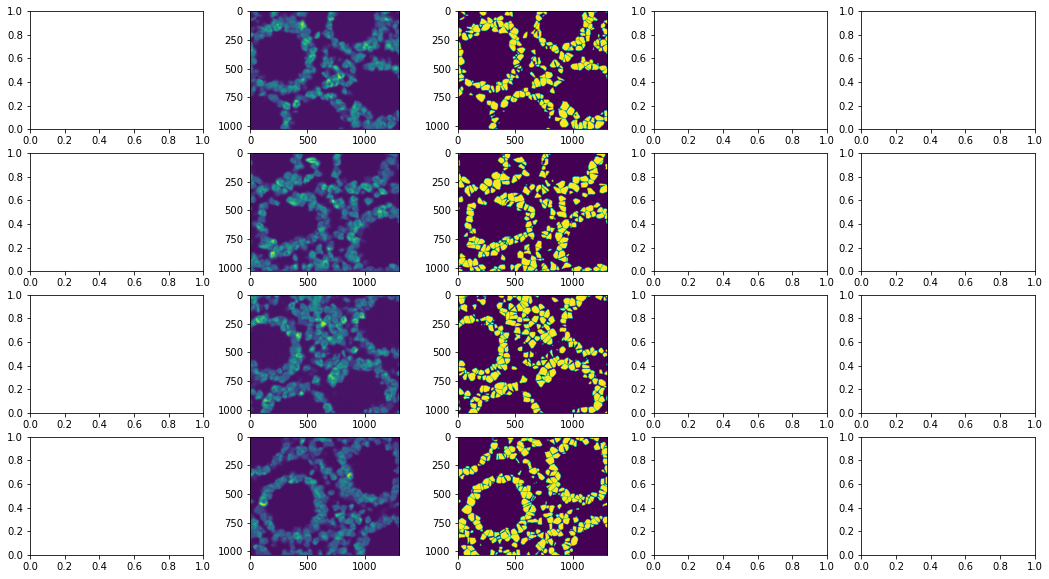

In [180]:
n_row = 4
fig, axes = plt.subplots(n_row, 5,sharex=False, sharey=False, figsize=(18,10))
n=0
# for i in valid_loader:
for i in train_loader:
    print(len(i),i[0].shape,i[1].shape)
    # img2plot=i['image']
    # label2plot=i['label']
    # print(img2plot.shape, label2plot.shape)

    # top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()

    # mask0= torch.max(label2plot[0,0,0,:,:,:],dim=-1)[0].detach().cpu()
    # mask1= torch.max(label2plot[0,0,1,:,:,:],dim=-1)[0].detach().cpu()
    # mask2= torch.max(label2plot[0,0,2,:,:,:],dim=-1)[0].detach().cpu()
    # mask3= torch.max(label2plot[0,0,2,:,:,:],dim=-1)[0].detach().cpu()
    zzz = 16
    # mask0= label2plot[0,0,0,:,:,zzz].detach().cpu()
    # mask1= label2plot[0,0,1,:,:,zzz].detach().cpu()
    # mask2= label2plot[0,0,2,:,:,zzz].detach().cpu()
    # mask3= label2plot[0,0,3,:,:,zzz].detach().cpu()
    # mask0= label2plot[0,0,:,:,zzz].detach().cpu()
    mask0= i[0][0][60].detach().cpu()
    mask1= i[1][0][60].detach().cpu()
    # mask2= label2plot[0,2,:,:,zzz].detach().cpu()
    # mask3= label2plot[0,3,:,:,zzz].detach().cpu()
    # mask1= label2plot[0,0,1,zzz,:,:].detach().cpu()
    # mask2= label2plot[0,0,2,:,zzz,:].detach().cpu()
    # mask3= label2plot[0,0,3,:,:,zzz].detach().cpu()
    # side_label= torch.max(label2plot[0,0,:,:,:],dim=-2)[0].detach().cpu()
    # print(mask0.max(),mask0.min())
    # print('mask2',mask2.max(),mask2.min())
    # axes[n,0].imshow(img2plot[0,0,:,:,zzz])

    
    axes[n,1].imshow(mask0)
    axes[n,2].imshow(mask1)
    # axes[n,3].imshow(mask2)
    # axes[n,4].imshow(mask3)
    n +=1
    if n>=n_row:
        break

In [92]:
import h5py
import tifffile as tf
import time
import numpy as np

def load_roi_from_hdf5(file_path, roi_start, roi_size):
    dataset_name ='Image'
    # a = np.zeros((100,100,1000), dtype=np.float32)
    a = np.random.rand(100,100,1000)
    a = a.copy()
    with h5py.File(file_path, 'r') as file:
        dataset = file[dataset_name]
        roi = dataset[roi_start[0]:roi_start[0]+roi_size[0], roi_start[1]:roi_start[1]+roi_size[1],roi_start[2]:roi_start[2]+roi_size[2]]
        # print(roi.shape)
    return roi



def load_roi_from_tiff(file_path, roi_start, roi_size):
    # a = np.zeros((1000,1000,1000), dtype=np.float32)
    # a = a.copy()
    img = tf.imread(file_path)
    # print(img.shape)
    roi = img[roi_start[0]:roi_start[0]+roi_size[0], roi_start[1]:roi_start[1]+roi_size[1],roi_start[2]:roi_start[2]+roi_size[2]]
    # print(roi.shape)
    return roi


def load_roi_from_zarr(file_path, roi_start, roi_size):
    """
    Load a 3D region of interest (ROI) from a Zarr file.

    Parameters:
    - file_path: Path to the Zarr file.
    - roi_start: A tuple (z, y, x) specifying the starting point of the ROI.
    - roi_size: A tuple (depth, height, width) specifying the size of the ROI.

    Returns:
    - roi_array: A 3D numpy array containing the specified ROI.
    """
    # Open the Zarr file
    dataset = zarr.open(file_path, mode='r')

    # Calculate the end indices of the ROI
    # roi_end = tuple(np.array(roi_start) + np.array(roi_size))

    # Extract the ROI from the dataset
    roi_array = dataset[roi_start[0]:roi_start[0]+roi_size[0], roi_start[1]:roi_start[1]+roi_size[1],roi_start[2]:roi_start[2]+roi_size[2]]

    return roi_array

In [93]:
from memory_profiler import memory_usage
import numpy as np
import time

def benchmark_loading(function, *args, iterations=100):
    times = []
    mem_usage = []

    for _ in range(iterations):
        start_time = time.time()
        # Measure peak memory usage of the function
        mem_peak = memory_usage((function, args), max_usage=True, retval=True)
        times.append(time.time() - start_time)
        mem_usage.append(mem_peak[0])  # memory_usage returns a tuple (memory, retval)
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    avg_mem = np.mean(mem_usage)
    std_mem = np.std(mem_usage)
    
    return avg_time, std_time, avg_mem, std_mem

# Usage example (Replace function calls and parameters as per your requirements)
# avg_time_hdf5, std_time_hdf5


# Example usage (you need to replace 'path/to/your' with actual file paths)
hdf5_path = '/data/download_data/colon_dataset/colon_30_hdf/images/*'
hdf5_file= glob.glob(hdf5_path)[0]

tiff_path = '/data/download_data/colon_dataset/colon_30/images/*.tif*'
tiff_file = glob.glob(tiff_path)[0]

zarr_path = '/data/download_data/colon_dataset/colon_30_zarr/images/*.zarr'
zarr_file = glob.glob(zarr_path)[0]

dataset_name = 'Image'
roi_start = (20, 100,100)
# roi_size = (50,256, 256)
roi_size = (25,25, 25)

# avg_time_hdf5, std_timt_hdf5 = benchmark_loading(load_roi_from_hdf5, hdf5_file, dataset_name, roi_start, roi_size)
# avg_time_tiff, std_tiff = benchmark_loading(load_roi_from_tiff, tiff_file, roi_start, roi_size)

# print(f"HDF5 loading time: {avg_time_hdf5:.5f} ± {std_hdf5:.5f} seconds")
# print(f"TIFF loading time: {avg_time_tiff:.5f} ± {std_tiff:.5f} seconds")


# Usage example (Replace function calls and parameters as per your requirements)
N_iterations =20
avg_time_hdf5, std_time_hdf5, avg_mem_hdf5, std_mem_hdf5 = benchmark_loading(load_roi_from_hdf5, hdf5_file, roi_start, roi_size, iterations=N_iterations)
avg_time_tiff, std_time_tiff, avg_mem_tiff, std_mem_tiff = benchmark_loading(load_roi_from_tiff, tiff_file, roi_start, roi_size, iterations=N_iterations)
avg_time_zarr, std_time_zarr, avg_mem_zarr, std_mem_zarr = benchmark_loading(load_roi_from_zarr, zarr_file, roi_start, 20*roi_size, iterations=N_iterations)

print(f"HDF5 - Time: {avg_time_hdf5:.5f} ± {std_time_hdf5:.5f} seconds, Memory: {avg_mem_hdf5:.2f} ± {std_mem_hdf5:.2f} MiB")
print(f"TIFF - Time: {avg_time_tiff:.5f} ± {std_time_tiff:.5f} seconds, Memory: {avg_mem_tiff:.2f} ± {std_mem_tiff:.2f} MiB")
print(f"Zarr - Time: {avg_time_zarr:.5f} ± {std_time_zarr:.5f} seconds, Memory: {avg_mem_zarr:.2f} ± {std_mem_zarr:.2f} MiB")



HDF5 - Time: 0.36428 ± 0.00136 seconds, Memory: 408.36 ± 0.01 MiB
TIFF - Time: 0.18736 ± 0.00164 seconds, Memory: 818.04 ± 35.91 MiB
Zarr - Time: 0.37062 ± 0.00796 seconds, Memory: 332.10 ± 0.00 MiB


In [94]:
avg_time_hdf5, std_time_hdf5, avg_mem_hdf5, std_mem_hdf5 = benchmark_loading(load_roi_from_hdf5, hdf5_file, roi_start, roi_size, iterations=N_iterations)
print(f"HDF5 - Time: {avg_time_hdf5:.5f} ± {std_time_hdf5:.5f} seconds, Memory: {avg_mem_hdf5:.2f} ± {std_mem_hdf5:.2f} MiB")

HDF5 - Time: 0.35634 ± 0.00304 seconds, Memory: 408.40 ± 0.00 MiB


In [95]:
avg_time_tiff, std_time_tiff, avg_mem_tiff, std_mem_tiff = benchmark_loading(load_roi_from_tiff, tiff_file, roi_start, roi_size, iterations=N_iterations)
print(f"TIFF - Time: {avg_time_tiff:.5f} ± {std_time_tiff:.5f} seconds, Memory: {avg_mem_tiff:.2f} ± {std_mem_tiff:.2f} MiB")

TIFF - Time: 0.17987 ± 0.00414 seconds, Memory: 818.08 ± 35.91 MiB


In [96]:
avg_time_zarr, std_time_zarr, avg_mem_zarr, std_mem_zarr = benchmark_loading(load_roi_from_zarr, zarr_file, roi_start, roi_size, iterations=N_iterations)
print(f"Zarr - Time: {avg_time_zarr:.5f} ± {std_time_zarr:.5f} seconds, Memory: {avg_mem_zarr:.2f} ± {std_mem_zarr:.2f} MiB")

Zarr - Time: 0.36383 ± 0.02114 seconds, Memory: 332.13 ± 0.00 MiB


In [208]:
# avg_time_tiff, std_time_tiff, avg_mem_tiff, std_mem_tiff = benchmark_loading(load_roi_from_tiff, tiff_file, roi_start, roi_size, iterations=5)
# print(f"TIFF - Time: {avg_time_tiff:.5f} ± {std_time_tiff:.5f} seconds, Memory: {avg_mem_tiff:.2f} ± {std_mem_tiff:.2f} MiB")

(50, 256, 256)
(50, 256, 256)


BlockingIOError: [Errno 11] Resource temporarily unavailable

In [86]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()